In [1]:
import sys
sys.path.append('../')
import numpy as np

# **SODA Implementation - Learning**

The main idea of SODA is to define specific **mechanism**, which can be modeled as an incomplete information game with continuous type (valuation/observation) and action spaces. By discretizing the type and action space, we construct an approximation **game**.
We then can apply different learning algorithms **learner** to compute Nash equilibria in the approximation game, which (hopefully) approximate the Bayes-Nash-Equilibrium of the mechanism

## **Mechanism**

Let's us start with a simple mechanism, the *First-Price Sealed Bid (FPSB)*. The FPSB is represented by the single item auction mechanism. Other available mechanisms are contest games, crowdsourcing, LLG auctions, double auctions and the split award auction.

In [2]:
from src.mechanism.single_item import SingleItemAuction 

The Single Item Auction is modelled as a Bayesian (Incomplete Information) Game which is defined by


\begin{equation}
    \Gamma = (N, V, A, F, u)
\end{equation}

- $N$ set of bidders (*bidder*)
- $V$ valuation (or observation) space for each bidder *o_space*
- $A$ action space for each bidder *a_space*
- *F* Prior distribution of valuation (types)
- $u_i:V_i \times A \rightarrow \mathbb{R}$ utility function (induced by auction format)

In [3]:
# bidder (if bidders have the same name, e.g. ['1', '1'], we assume that they're symmetric and we learn one strategy for both.
# We use the symmetric version whenever possible.
bidder = ['1', '1']

# the type and action space (interval [0,1]) for each bidder
o_space = {'1': [0, 1]}
a_space = {'1': [0, 1]}

# prior distribution (i.i.d. uniform)
param_prior = {'distribution': 'uniform'}

# utility function (first price sealed bid with a tie-breaking rule where no one wins at tiesm utility_type:QL refers to Quasi-linear and is the setting we use)
param_util = {'payment_rule':'first_price', 'tie_breaking': 'lose', 'utility_type':'QL'}

All this configurations can be found in the *config* directory.

In [4]:
mechanism = SingleItemAuction(bidder, o_space, a_space, param_prior, param_util)

The central aspect of the mechanism is the utility function. If for the first bidder (idx=0) has a valuation of 1.0 and bids 0.6, while her opponent bids 0.3, then she wins with a payoff of 1.0-0.6:

In [8]:
value_profile = np.array([1.0, 0.5])
bids_profile = np.array([0.6, 0.3])
mechanism.utility(value_profile, bids_profile, index_agent=0)

0.4

### **Game**

Now given the mechanism, we can define a discretized approximation game.
We only have to specify the number of discretization points for valuation (*n*) and action space (*m*) and pass the respective mechanism to the constructor.

In [9]:
from src.game import Game

In [10]:
n = 20
m = 21
game = Game(mechanism, n, m)

The valuation and action space for each bidder is now discretized --> game.o_discr[agent] and game.a_discr[agent]. For the observations we discretize by taking the midpoints of n subintervals, while the action space is discretized using m equidistant points including the lower and upper bound.

In [11]:
game.a_discr['1']

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

To compute the gradient etc. for the learning algorithm, we have to compute the utility for all possible bids and valuations beforehand for each bidder.

In [12]:
game.get_utility()

As we can see here, the computed utility is an array with 21x21x20 entries which corresponds to all possible combinations of bids of both players and observation of player '1'. 
If bidder 1 submits its discrete bid with index 6 and bidder 2 the discrite bid with index 3, while bidder 1 values the item according to its discrete valuation with index 10 then we have the following utility:

In [13]:
game.utility['1'][6,3,10]

0.22500000000000003

### **Distributional Strategies**

Given the discretied *game* we can now define distributional strategies $s_i \in S_i$, i.e., probability measures over the discretized valuation and action space. The discretized game with the distributional strategies and the expected utilities $\tilde u_i$ define a normal form game, i.e., the approximation game:


\begin{equation}
    G = (N, S, \tilde u)
\end{equation}

In [14]:
from src.strategy import Strategy

In [15]:
strategies = {}
for i in game.bidder:
    strategies[i] = Strategy(i, game)
    strategies['1'].initialize('random')

The distributional strategy can be interpreted as a matrix, where each entry (i,j) corresponds to the probability assigned to playing bid j together with valuation i.
If we initialize the strategy randomly, each (bid,valuation) pair gets a random probability assigned (white=low, dark=high).

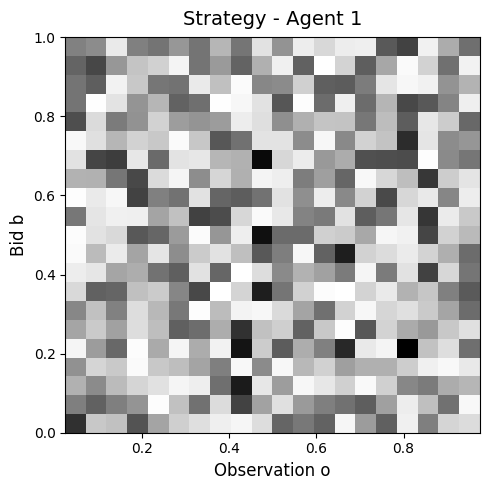

In [16]:
strategies['1'].plot()

Since it is a probability measure, all entries add up to 1.

In [17]:
strategies['1'].x.sum()

1.0

### **Learning Algorithm**

Since our approximation game is a normal form game and since we can compute the gradient w.r.t. the distributional strategies, we can apply standard learning algorithm. One method is for instance the gradient descent with lazy projections which is a special case of the implemented simultaneous online dual averaging (SODA) with an Euclidean regularizer.

In [18]:
from src.learner.soma import SOMA

First we have to define some general parameters which are applicable to all learning algorithms:
The algorithm stops after *max_iter* iterations or earlier, whenever the value of the stopping criteration is below *tol*.
The other parameters are specific for the algorithm and can differ for other methods.

In [19]:
# General parameters for leanring algorithm
max_iter = 5000
tol = 1e-4
stop_criterion = 'util_loss'

# Specific parameters for POGA (step size)
param_learner = {
    "mirror_map": 'euclidean',
    "steprule_bool": True,
    "eta": 1.0,
    "beta": 0.5,    
}


In [20]:
learner = SOMA(max_iter, tol, stop_criterion, param_learner)

To apply the learning algorithm to our strategies, we simply call:

In [21]:
learner.run(game, strategies, disable_tqdm_bool=False, print_result_bool=True, save_history_bool=True)

100%|████████████████████| 5.00k/5.00k [00:00<00:00, 5.76kit/s]

No convergence with stopping criterion
Current value of (util_loss): 0.00062
Best value of (util_loss)   : 0.00010)


The result of the learning algorithm is:

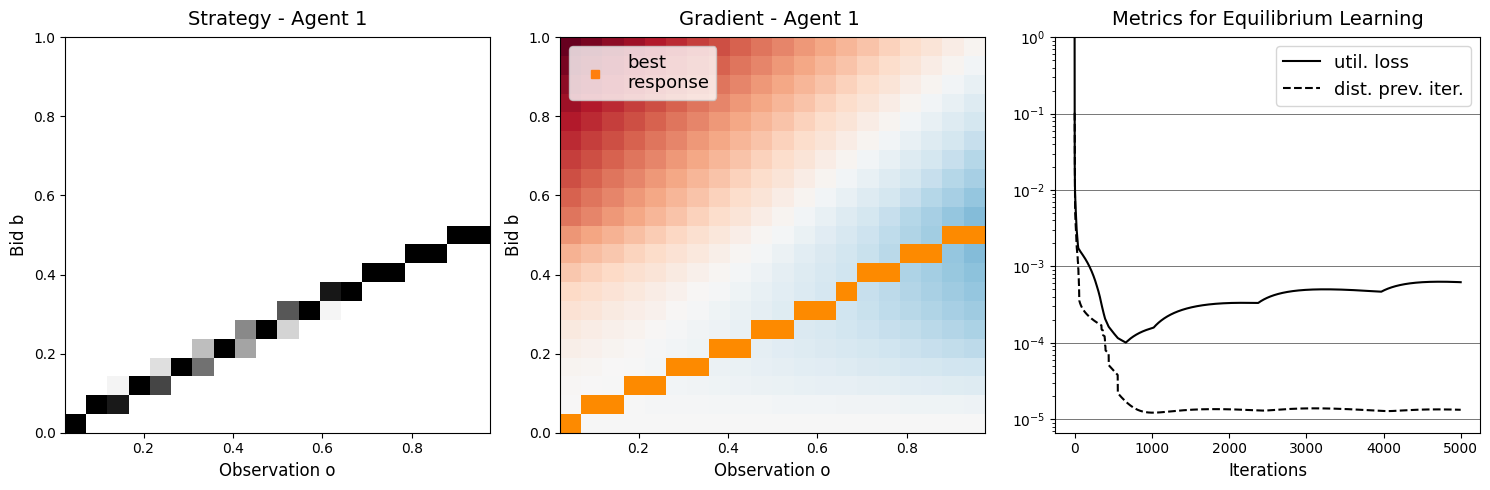

In [22]:
strategies['1'].plot(grad=True, metrics=True)

### **Analyzing Results**

We can look at some metrics (more=True) and compare it with the analytical BNE $\beta(v) = 0.5 v$

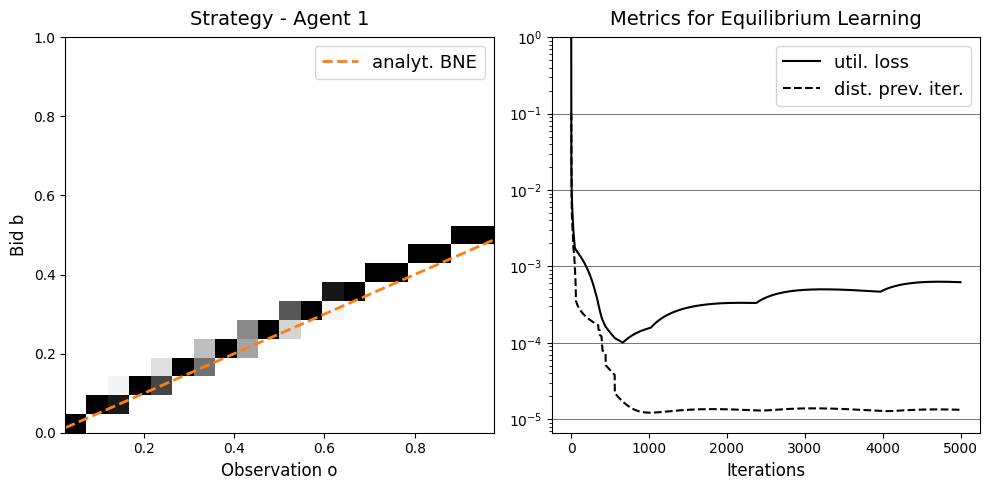

In [23]:
strategies['1'].plot(metrics=True, beta = lambda x: 0.5 *x)

We can also access the history of all computed strategies and gradients. For instance the strategy and the corresponding gradient after iter=100 iterations.

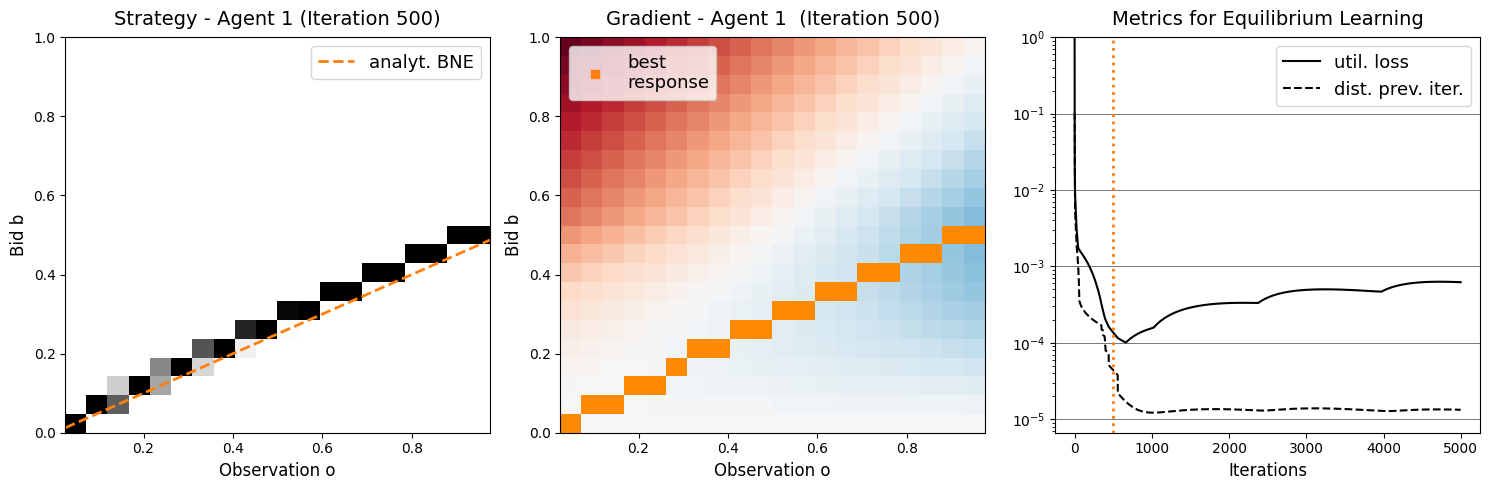

In [24]:
iter = 500
strategies['1'].plot(grad=True, metrics=True, iter=iter, beta=lambda x: 0.5*x)

In [25]:
print(f'Utility after {iter} iterations:'.ljust(50), round(strategies['1'].utility[iter],5))
print(f'Relative utility loss after {iter} iteraitons:'.ljust(50), round(strategies['1'].utility_loss[iter],5))

Utility after 500 iterations:                      0.14332
Relative utility loss after 500 iteraitons:        0.00014


### **How to use config-files**

In the directory _configs_ you can find config files for different settings. This makes creating mechanism, games, and learners easier.
To be able to use this we need some additional methods from _util_

In [26]:
from src.util.config import Config

First we have to define where we can find the config files

In [27]:
mechanism_type = 'single_item'  # subdirectory of configs
experiment = 'fpsb_intro'       # name of a file in the configs/setting directory
learn_alg = 'frank_wolfe'       # name of a file in the configs/setting/learner directory

No we can import the configurations and create mechanism, game and learner

In [28]:
config = Config()
# path from soda/ to directory with configs
config.get_path("configs/")
game, learner = config.create_setting(mechanism_type, experiment, learn_alg)

After we create and initialize the strategies we are ready to run (similar to the longer version above)

In [29]:
strategies = config.create_strategies(game, "random")

In [30]:
learner.run(game, strategies, disable_tqdm_bool=False, print_result_bool=True, save_history_bool=True)

 10%|█▉                  | 98.0/1.00k [00:00<00:00, 6.27kit/s]

Convergence after 999 iterations
Value of stopping criterion (util_loss) 0.0001


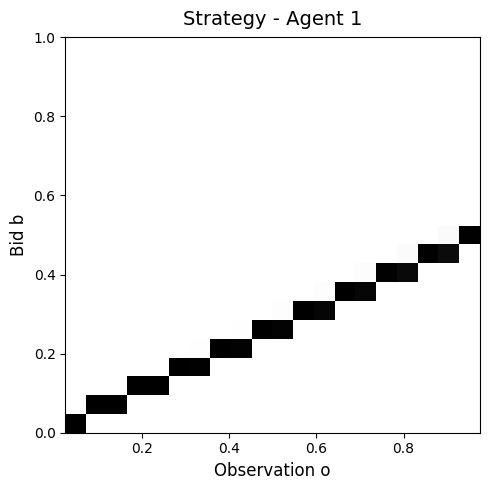

In [31]:
strategies['1'].plot()